<a href="https://colab.research.google.com/github/YoshihiroOhtsuka-lab/JSTMHPE2026/blob/main/example2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian ANOVA using the mixed effects model

## 分析準備

In [ ]:
!pip install pymc

In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import pytensor.tensor as pt
# オプション設定
az.style.use("arviz-whitegrid")
# 表示の桁数設定
pd.options.display.precision = 3

## データの取得と可視化

   subject  period treatment    y
0        0       0         B -160
1        0       1         C  -81
2        0       2         A  -11
3        1       0         C -155
4        1       1         B -119


Text(0, 0.5, '$\\Delta y$')

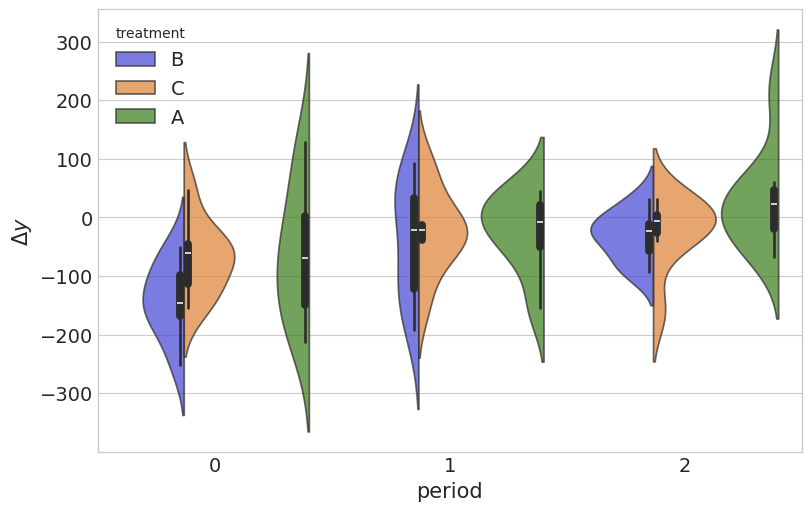

In [ ]:
# データのURL
url ='https://raw.githubusercontent.com/YoshihiroOhtsuka-lab/JSTMHPE2026/main/example2_data.xlsx'
df = pd.read_excel(url)
print(df.head())

# figure
fig, ax = plt.subplots(figsize=(8, 5))
sns.violinplot(x='period', y='y', hue='treatment',
               data=df, split=True, alpha=0.7, ax=ax)
ax.set_ylabel("$\\Delta y$")

ラベルの設定

In [ ]:
n_subjects = df['subject'].nunique()

# カテゴリーラベルの設定
df['trt_idx'] = df['treatment'].astype('category').cat.codes
df['period_idx'] = df['period']
df['sub_idx'] = df['subject']

# コードインデックスの作成
coords = {
    "obs": np.arange(len(df)),
    "subject": np.arange(n_subjects),
    "treatment": np.arange(3),
    "period": np.arange(3)
}

## Mixed effects modelのMCMC

### モデルの設定

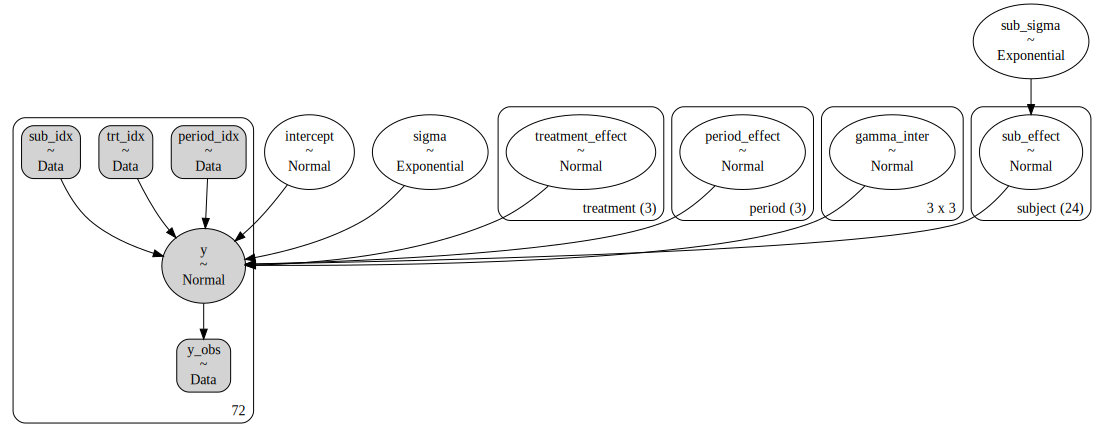

In [ ]:
with pm.Model(coords=coords) as interaction_model:
    # データセット
    y_obs = pm.Data("y_obs", df['y'].values)
    trt_idx = pm.Data("trt_idx", df['trt_idx'].values)
    period_idx = pm.Data("period_idx", df['period_idx'].values)
    sub_idx = pm.Data("sub_idx", df['sub_idx'].values)

    # 事前分布
    # 全体の平均
    intercept = pm.Normal("intercept", mu=np.mean(df['y']), sigma=5)

    # 施策効果
    treatment_effect = pm.Normal("treatment_effect", mu=0, sigma=5, dims="treatment")

    # 時間効果
    period_effect = pm.Normal("period_effect", mu=0, sigma=5, dims="period")

    # 3交互作用行列
    gamma_inter = pm.Normal("gamma_inter", mu=0, sigma=5, shape=(3, 3))

    # 被験者ランダム効果
    sub_sigma = pm.Exponential("sub_sigma", 1.0)
    sub_effect = pm.Normal("sub_effect", mu=0, sigma=sub_sigma, dims="subject")

    # 誤差項の標準偏差
    sigma = pm.Exponential("sigma", 1.0)

    # 交互作用項は [treat, period] のインデックスで抽出
    mu = (intercept +
          treatment_effect[trt_idx] +
          period_effect[period_idx] +
          sub_effect[sub_idx] +
          gamma_inter[trt_idx, period_idx]
          )

    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)

outline = pm.model_to_graphviz(interaction_model)
outline.attr(rankdir='TB')
outline.render("model1", format="png", cleanup=True)
outline

### MCMCの実行

In [ ]:
# サンプリング
n_draws = 2000
n_chains = 2
n_tunes = 1000

with interaction_model:
    trace_inter = pm.sample(draws=n_draws,
                    chains=n_chains,
                    tune = n_tunes,
                    target_accept=0.95,
                    random_seed=123)
    trace_inter.extend(pm.sample_prior_predictive(n_draws*n_chains))
    # compute log likelihood
    pm.compute_log_likelihood(trace_inter)

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

### 結果の出力

In [ ]:
# 結果の要約
summary = az.summary(trace_inter,
                     var_names=["intercept",
                                "treatment_effect", "period_effect",
                                "gamma_inter", "sub_sigma"
                                ],
                     hdi_prob=0.95,
                     kind='stats'
                     )
print(summary)

                       mean     sd  hdi_2.5%  hdi_97.5%
intercept           -42.641  4.258   -51.502    -34.731
treatment_effect[0]   3.290  4.863    -5.692     13.308
treatment_effect[1]  -3.842  4.701   -12.768      5.381
treatment_effect[2]   0.464  4.703    -9.149      9.376
period_effect[0]     -6.415  4.580   -15.330      2.211
period_effect[1]      1.847  4.764    -7.504     10.677
period_effect[2]      4.628  4.885    -5.312     13.608
gamma_inter[0, 0]    -0.866  4.857    -9.897      8.575
gamma_inter[0, 1]     0.577  4.804    -8.779      9.820
gamma_inter[0, 2]     3.512  4.823    -6.247     12.582
gamma_inter[1, 0]    -4.521  5.000   -13.579      5.692
gamma_inter[1, 1]     0.298  4.821    -8.697     10.051
gamma_inter[1, 2]     0.543  4.805    -8.799      9.797
gamma_inter[2, 0]    -1.234  4.864   -10.490      8.399
gamma_inter[2, 1]     1.005  4.974    -8.847     10.187
gamma_inter[2, 2]     0.492  4.982    -8.952     10.570
sub_sigma             1.071  0.989     0.035    

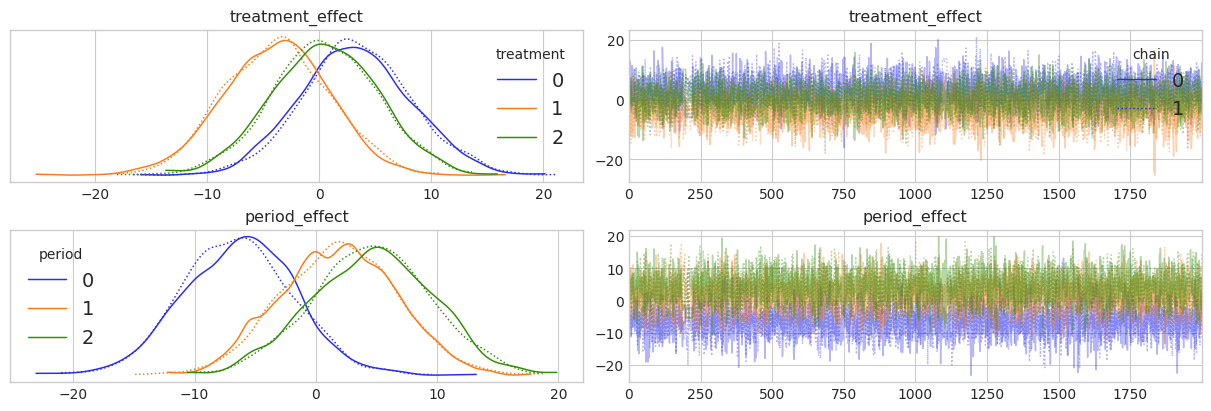

In [ ]:
# 処置効果と時間効果の可視化
az.plot_trace(trace_inter,
              var_names=["treatment_effect","period_effect"],
              legend=True
              )
plt.show()

treatmentのラベルは0->A, 1->B, 2->C

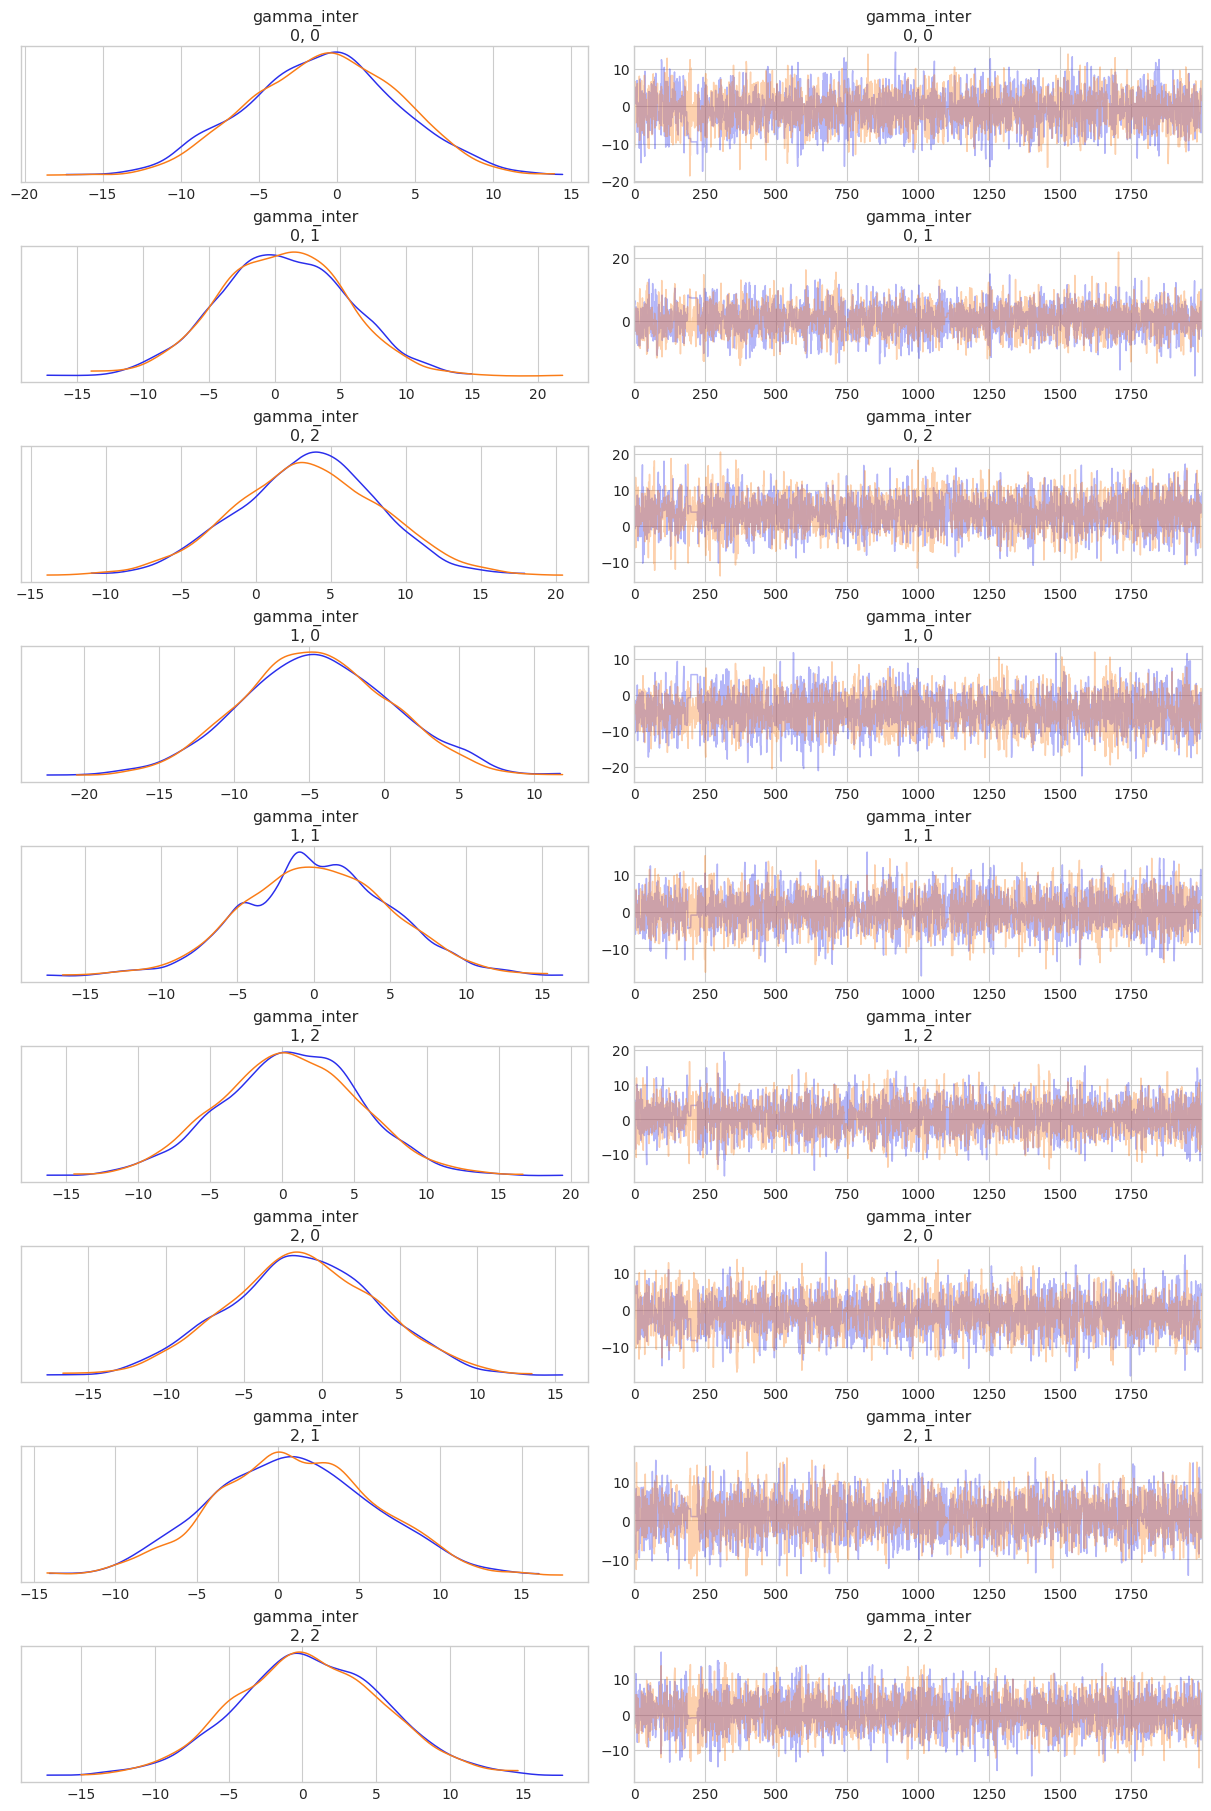

In [ ]:
# 交互作用の可視化
az.plot_trace(trace_inter,
              var_names=["gamma_inter"],
              compact=False
              )
plt.show()

### 処置効果の検証

#### ROPEによる検証

array([<Axes: title={'center': 'treatment_effect\n0'}>,
       <Axes: title={'center': 'treatment_effect\n1'}>,
       <Axes: title={'center': 'treatment_effect\n2'}>], dtype=object)

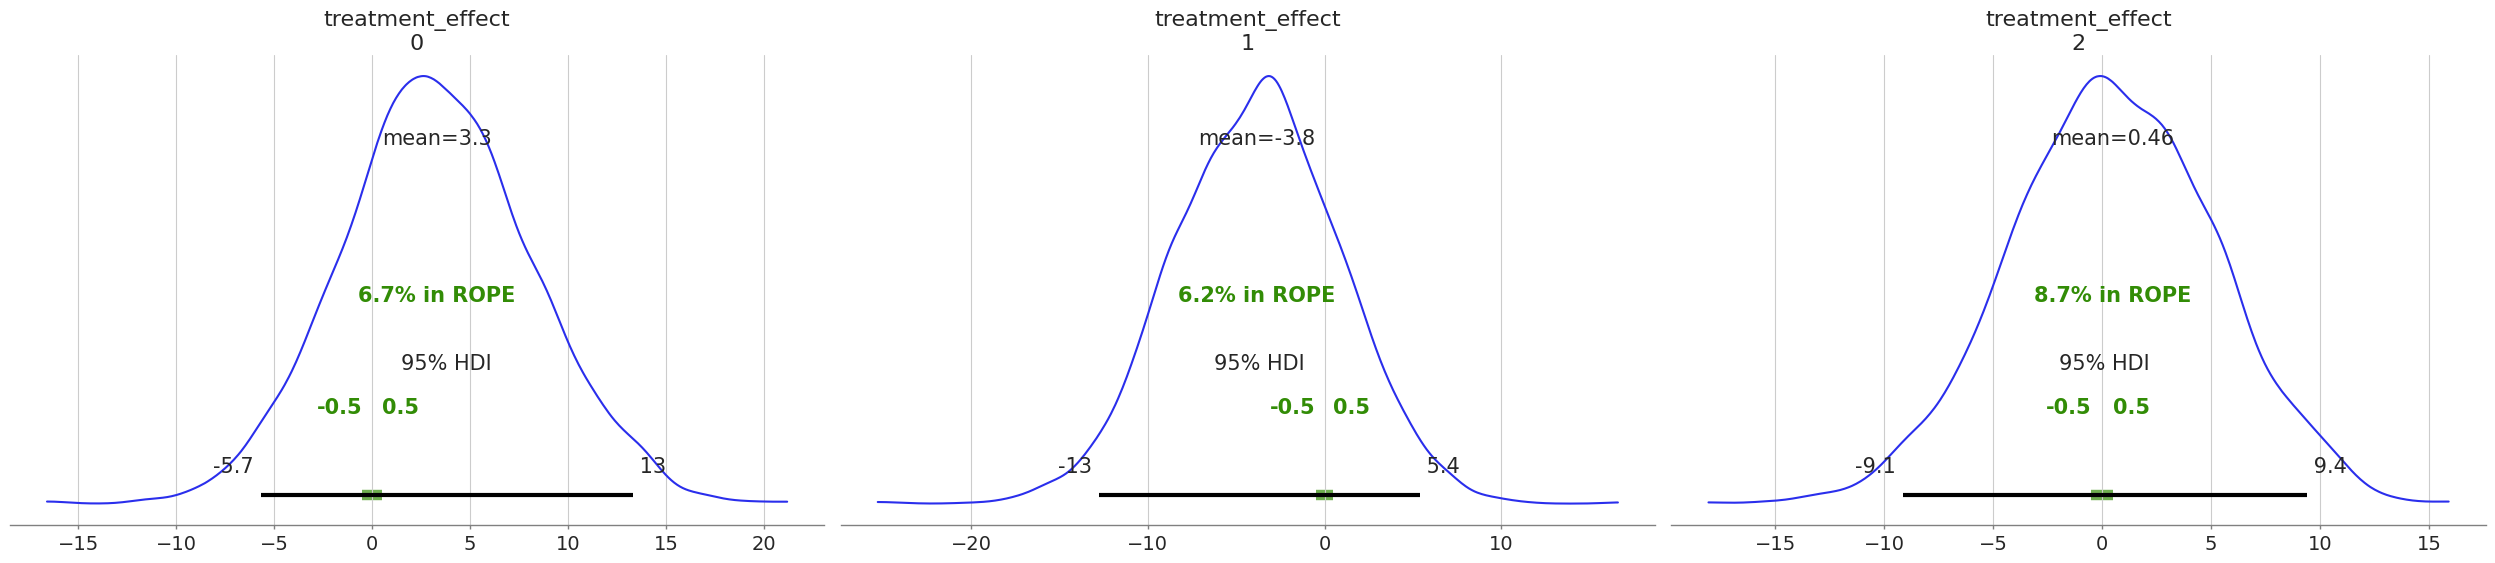

In [ ]:
az.plot_posterior(trace_inter.posterior['treatment_effect'], hdi_prob=0.95, rope=[-0.5, 0.5])

####ベイズ因子による検証

In [ ]:
#　Treatmentの有意性をベイズ因子で調べる
bf_results = pd.DataFrame()

for i in range(3):
  subset_idata = trace_inter.sel(treatment=[i])
  bf_res = az.bayes_factor(subset_idata, var_name="treatment_effect", ref_val=0)
  bf_results.loc[i, "BF10"] = bf_res["BF10"]
  bf_results.loc[i, "BF01"] = bf_res["BF01"]

bf_results.index = ["A", "B", "C"]

bf_results

Posterior distribution has {posterior.ndim} dimensions


,BF10,BF01
A,1.139,0.878
B,1.236,0.809
C,0.965,1.036


###交互作用効果の検証

In [ ]:
bf_results_inter = pd.DataFrame()
for i in range(3):
  for j in range(3):
    subset_idata = trace_inter.sel(gamma_inter_dim_0=[i], gamma_inter_dim_1=[j])
    bf_res = az.bayes_factor(subset_idata, var_name="gamma_inter", ref_val=0)
    bf_results_inter.loc[f"{i}{j}", "BF10"] = bf_res["BF10"]
    bf_results_inter.loc[f"{i}{j}", "BF01"] = bf_res["BF01"]

label = ["A", "B", "C"]
bf_results_inter.index = [f"gamma({label[i]},{str(j)})" for i in range(len(label)) for j in range(3)]
bf_results_inter

,BF10,BF01
"gamma(A,0)",0.976,1.025
"gamma(A,1)",0.999,1.001
"gamma(A,2)",1.230,0.813
"gamma(B,0)",1.438,0.696
"gamma(B,1)",0.968,1.033
"gamma(B,2)",0.983,1.018
"gamma(C,0)",0.988,1.013
"gamma(C,1)",1.021,0.979
"gamma(C,2)",0.986,1.014


## 交互作用効果の必要性

### 交互作用効果無しのモデル設定とMCMC

In [ ]:
with pm.Model(coords=coords) as crossover_model:
    # データセット
    y_obs = pm.Data("y_obs", df['y'].values)
    trt_idx = pm.Data("trt_idx", df['trt_idx'].values)
    period_idx = pm.Data("period_idx", df['period_idx'].values)
    sub_idx = pm.Data("sub_idx", df['sub_idx'].values)

    # Priors
    # 全体の平均
    intercept = pm.Normal("intercept", mu=np.mean(df['y']), sigma=5)

    # 施策効果
    treatment_effect = pm.Normal("treatment_effect", mu=0, sigma=5, dims="treatment")

    # 時間効果
    period_effect = pm.Normal("period_effect", mu=0, sigma=5, dims="period")

    # 個体効果
    sub_sigma = pm.Exponential("sub_sigma", 1.0)
    sub_effect = pm.Normal("sub_effect", mu=0, sigma=sub_sigma, dims="subject")

    sigma = pm.Exponential("sigma", 1.0)

    mu = (intercept +
          treatment_effect[trt_idx] +
          period_effect[period_idx] +
          sub_effect[sub_idx])

    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)
    # サンプリング
    trace_cross = pm.sample(draws=n_draws,
                    chains=n_chains,
                    tune = n_tunes,
                    #target_accept=0.95,
                    random_seed=123)
    trace_cross.extend(pm.sample_prior_predictive(n_draws*n_chains))
    # compute log likelihood
    pm.compute_log_likelihood(trace_cross)

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

### モデル比較

In [ ]:
model_dict = {"interaction": trace_inter, "crossover": trace_cross}
comp = az.compare(model_dict, method='BB-pseudo-BMA')
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
interaction,0,-429.824,4.314,0.000,0.599,11.922,0.00,False,log
crossover,1,-430.237,3.532,0.414,0.401,11.924,0.33,False,log


モデルの良さはランクを見れば良い